In [1]:
!pip install analytic_wfm
!pip install xgboost

In [0]:
import os
import pandas as pd
import scipy.io
import analytic_wfm as aw
import numpy as np
from scipy.signal import savgol_filter
from scipy.interpolate import splrep, splev
from sklearn import preprocessing
import matplotlib.pyplot as plt

from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import Matern

from sklearn.model_selection import LeaveOneOut
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error


In [0]:
mdic = {
    'step': 0,
    'comment': 0,
    'type': 1,
    'time': 2,
    'rel time': 3,
    'voltage': 4,
    'current': 5,
    'temp': 6,
    'date': 7
}

In [0]:
def get_matlab_data(matlab_file, cycle, data_labels):
    """
    matlab file opened by scipy.io
    cycle = cycle number to get data for
    data labels is the data you want to extract, i.e current, voltage, time etc, look at the dict above to see the options
    
    """
    
    result_array = np.empty((len(data_labels), matlab_file['data'][0,0][0][0, cycle-1][mdic[data_labels[0]]][0].size))
    for idx, label in enumerate(data_labels):
        result_array[idx] = matlab_file['data'][0,0][0][0, cycle-1][mdic[label]][0]
    return result_array


In [5]:
s = 0.01

df = pd.DataFrame(columns=['dQdV Peak location', 'dQdV Peak height', 'dVdQ Peak location', 'dVdQ Peak height', 'Capacity', 'File', 'Cycle', 'total time'])

delta=0.0
lookahead=1
for file in os.listdir('Drive/My Drive/Research Project/Colab Data/NASA dataset matlab files/'):
    mat = scipy.io.loadmat(f'Drive/My Drive/Research Project/Colab Data/NASA dataset matlab files/{file}')
    
    df_len = len(df)

    ref_dis_idx = []
    ref_cha_idx = []
    for count, item in  enumerate(mat['data'][0,0][0][0]):
        if item[0][0] == 'reference discharge':
            ref_dis_idx.append(count+1)
        elif item[0][0] == 'reference charge':
            ref_cha_idx.append(count+1)
    initial_capacity = get_matlab_data(mat, ref_dis_idx[0], ['current'])[0].max()        
    for count, cycle in enumerate(ref_dis_idx):
        try:
            data = get_matlab_data(mat, cycle, ['rel time', 'voltage', 'current', 'time'])
            voltage = savgol_filter(data[1], 51, 5)
            mask = voltage < 3.8
            current = data[2][mask].mean()
            f = splrep(data[0][mask], voltage[mask], k=5, s=s)
            main_peaks = aw.peakdetect(1/splev(data[0][mask], f, der=1), splev(data[0][mask], f), lookahead=lookahead, delta=delta)
            
            minima, minima_height = zip(*main_peaks[1])
            if len(minima) > 1:
                idx = np.argmin(minima_height)
            else:
                idx = 0
            output = main_peaks[1][idx]
            
            f = splrep(data[0], voltage, k=5, s=s)
            main_peaks = aw.peakdetect(splev(data[0], f, der=1), data[0], lookahead=lookahead, delta=delta)
            maxima, maxima_height = zip(*main_peaks[0])
            
            if len(maxima) > 1:
                idx = np.argmax(maxima_height)
            else:
                idx = 0
            if maxima_height[idx] > 0:
                print(f'{file}, cycle {cycle} maxima above 0')
            else:
                output = output + main_peaks[0][idx]

    #             output.append(initial_capacity*current/3600)
                output.append(data[0].max()*current/3600)
                output.append(file.split('.')[0])
                output.append(cycle)
                output.append(data[3].max()/(24*60*60))
    #             print(output)
                if output[1] > -60000:
                    df.loc[count+df_len] = output
                else:
                    print(f'{file}, cycle {cycle} peak weirdly large')
        except Exception as e:
            print(f'{file}, cycle {cycle}, {e}')
            pass

RW7.mat, cycle 5998 maxima above 0
RW9.mat, cycle 30258 peak weirdly large
RW10.mat, cycle 30256 maxima above 0
RW12.mat, cycle 66994 maxima above 0
RW17.mat, cycle 3383, If mode is 'interp', window_length must be less than or equal to the size of x.
RW18.mat, cycle 3150, If mode is 'interp', window_length must be less than or equal to the size of x.
RW19.mat, cycle 3374, If mode is 'interp', window_length must be less than or equal to the size of x.


# Plotting the features

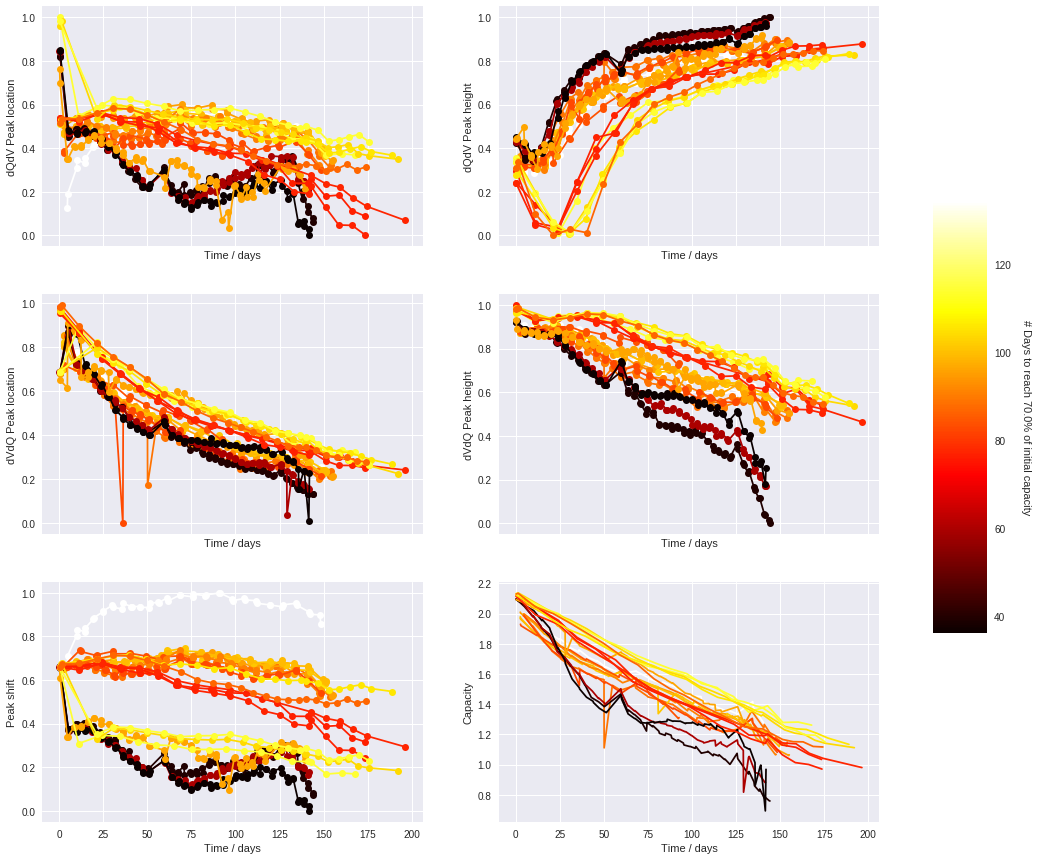

In [6]:
end_point_dic = {}
cap_cutoff = 0.7
col_list  = ['dQdV Peak location', 'dQdV Peak height', 'dVdQ Peak location', 'dVdQ Peak height', 'Peak shift', 'Capacity']
# col_list = ['dQdV Peak location', 'Capacity']

for file in df['File'].unique():
    df_file = df[df['File'] == file].copy()
    df_file['Cap %'] = df_file['Capacity']/df_file['Capacity'].max()
    if len(df_file[df_file['Cap %'] < cap_cutoff]) < 1:
        pass
    else:
        df_file = df_file[df_file['Cap %'] > cap_cutoff]
#         plt.plot(df_file['total time'], df_file['Cap %'], marker='o', label=file)
        end_point_dic.update({file: df_file['total time'].max()})
    
for file in df['File'].unique():
    idx = df[df['File'] == file].index
    initial_peak = df.loc[idx[0], 'dQdV Peak location']
    df.loc[idx, 'Peak shift'] = df.loc[idx, 'dQdV Peak location'] - initial_peak
    

fig, axes = plt.subplots(int(np.ceil(len(col_list)/2)), 2, sharex=True, figsize=(15,15))

files_to_plot = end_point_dic.keys()

cm = plt.get_cmap('hot')
norm = plt.Normalize(vmin=min(list(end_point_dic.values())), vmax=max(list(end_point_dic.values()))) 
sm = plt.cm.ScalarMappable(cmap=cm, norm=norm)
# fake up the array of the scalar mappable. Urgh...
sm._A = []


# cbar = fig.colorbar(sm)



scaler = preprocessing.MinMaxScaler()
min_max_scaled_df = scaler.fit_transform(df[col_list])


df2 = df.reset_index()
for count, ax in enumerate(fig.axes):
    item = col_list[count]
    if (item != 'Capacity'):
        for file in files_to_plot:
            idx = df2[df2['File'] == file].index
            ax.plot(df2.loc[idx, 'total time'], min_max_scaled_df[idx, count], color=cm(norm(end_point_dic[file])), marker='o')

            ax.set_ylabel(item)
            ax.set_xlabel('Time / days')
    else:
        for file in files_to_plot:
            idx = df2[df2['File'] == file].index
            ax.plot(df2.loc[idx, 'total time'], df2.loc[idx, item], color=cm(norm(end_point_dic[file])), label=file)

            ax.set_ylabel(item)
            ax.set_xlabel('Time / days')

            
cbar_ax = fig.add_axes([0.95, 0.3, 0.05, 0.4])
cbar = fig.colorbar(sm, cax=cbar_ax)
cbar.set_label(f'# Days to reach {cap_cutoff*100}% of initial capacity', rotation=270, labelpad=20)

# plt.legend()

# Gaussian regressions

In [0]:
time_values = np.array([5, 10, 15, 20, 25, 30])

max_input_t = time_values.max()

ty_list = [30, 40, 50, 60, 70, 80, 90, 100, 105, 110, 115, 118, 120, 123, 125, 128, 130, 133, 135, 138]

col_list = ['dQdV Peak location', 'dQdV Peak height', 'dVdQ Peak location', 'dVdQ Peak height', 'Peak shift', 'Capacity']
# col_list = ['dQdV Peak location', 'Capacity']

for file in df['File'].unique():
    df_file = df[df['File'] == file].copy()
    df_file['Cap %'] = df_file['Capacity']/df_file['Capacity'].max()
    if len(df_file[df_file['Cap %'] < cap_cutoff]) < 1:
        pass
    else:
        df_file = df_file[df_file['Cap %'] > cap_cutoff]
#         plt.plot(df_file['total time'], df_file['Cap %'], marker='o', label=file)
        end_point_dic.update({file: df_file['total time'].max()})
    
del end_point_dic['RW6']

files_to_plot = end_point_dic.keys()

In [0]:

# col_list = ['dQdV Peak location', 'dQdV Peak height', 'dVdQ Peak location', 'dVdQ Peak height', 'Peak shift', 'Capacity']

# +1 as also have the initial time value
# all_RMSPE_lists = []
# for col_list in [
#     ['dQdV Peak location', 'dQdV Peak height', 'dVdQ Peak location', 
#      'dVdQ Peak height', 'Peak shift', 'Capacity'],
#     ['dQdV Peak location', 'Capacity'],
#     ['dQdV Peak height', 'Capacity'],
#     ['Capacity'],
#     ['dVdQ Peak location', 'Capacity'],
#     ['dVdQ Peak height', 'Capacity']
#                 ]:
for col_list in [['dQdV Peak location', 'dQdV Peak height', 'Capacity']]:
    X_total = np.ndarray((len(files_to_plot), (len(time_values)+1)*len(col_list)))

    for count, file in enumerate(files_to_plot):
        df_file = df[df['File'] == file]
        time = df_file['total time']
        X = np.array([])
        for item in col_list:
            time_series = df_file[item]

            f = splrep(time, time_series, k=1, s=0.0)

            X = np.append(X, [list(time_series)[0]])
            X = np.append(X, splev(time_values, f))

        X_total[count, :] = X

    ## Getting y
    def getting_y(ty):
        y = np.array([])
        for file in files_to_plot:
            df_file = df[df['File'] == file]
            capacity = df_file['Capacity']
            time = df_file['total time']
            f = splrep(time, capacity, k=1, s=0.0)
            y = np.append(y, splev(ty, f))

        return y

    scaler = preprocessing.MinMaxScaler()
    X_scaled = scaler.fit_transform(X_total)

    average_RMSPE_all = []
    y_var_list = []

    y_pred_df = pd.DataFrame(index=files_to_plot, columns=ty_list)
    for ty in ty_list:

        y = getting_y(ty)
        y_var_list.append(np.sqrt(np.var(y)))

        RMSPE_list = []

        kernel = Matern(length_scale=1, nu=1.5)
        gp = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=50, normalize_y=True, alpha=1e-3)


        loo = LeaveOneOut()
        y_pred = cross_val_predict(gp, X_scaled, y, cv=loo)
        score = mean_squared_error(y, y_pred)
        average_RMSPE_all.append(score)
        y_pred_df.loc[:, ty] = y_pred
        
    all_RMSPE_lists.append(average_RMSPE_all)

Text(0.5,0,'Time / days')

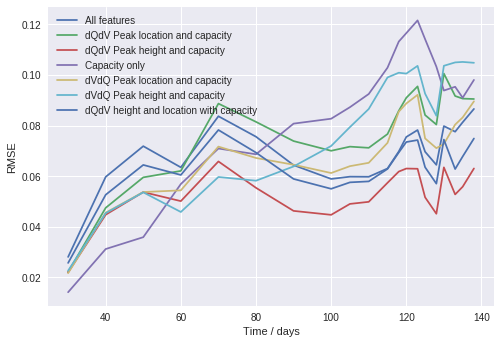

In [17]:
label_list = ['All features', 'dQdV Peak location and capacity', 'dQdV Peak height and capacity', 'Capacity only', 'dVdQ Peak location and capacity', 'dVdQ Peak height and capacity', 'dQdV height and location with capacity']

for count, item in enumerate(all_RMSPE_lists):
    plt.plot(ty_list, [np.sqrt(i) for i in item], label=label_list[count])
plt.legend()
plt.ylabel('RMSE')
plt.xlabel('Time / days')

In [9]:
plt.plot(ty_list, [np.sqrt(i) for i in average_RMSPE]) 

NameError: ignored

In [0]:
col_list = ['Capacity']


# +1 as also have the initial time value
X_total = np.ndarray((len(files_to_plot), (len(time_values)+1)*len(col_list)))

for count, file in enumerate(files_to_plot):
    df_file = df[df['File'] == file]
    time = df_file['total time']
    X = np.array([])
    for item in col_list:
        time_series = df_file[item]
        
        f = splrep(time, time_series, k=1, s=0.0)
        
        X = np.append(X, [list(time_series)[0]])
        X = np.append(X, splev(time_values, f))
        
    X_total[count, :] = X
    
## Getting y
def getting_y(ty):
    y = np.array([])
    for file in files_to_plot:
        df_file = df[df['File'] == file]
        capacity = df_file['Capacity']
        time = df_file['total time']
        f = splrep(time, capacity, k=1, s=0.0)
        y = np.append(y, splev(ty, f))
        
    return y

scaler = preprocessing.MinMaxScaler()
X_scaled = scaler.fit_transform(X_total)

average_RMSPE_cap_only = []
y_var_list = []

y_pred_df_cap_only = pd.DataFrame(index=files_to_plot, columns=ty_list)
for ty in ty_list:
    
    y = getting_y(ty)
    y_var_list.append(np.sqrt(np.var(y)))
    
    RMSPE_list = []
    
    kernel = Matern(length_scale=1, nu=1.5)
    gp = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=50, normalize_y=True, alpha=1e-3)

    
    loo = LeaveOneOut()
    y_pred = cross_val_predict(gp, X_scaled, y, cv=loo)
    score = mean_squared_error(y, y_pred)
    average_RMSPE_cap_only.append(score)
    y_pred_df_cap_only.loc[:, ty] = y_pred

Text(0.5,0,'Time / days')

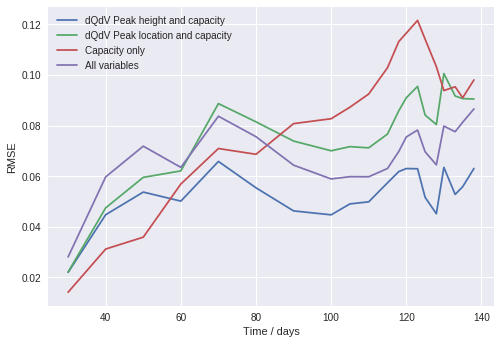

In [159]:
plt.plot(ty_list, [np.sqrt(i) for i in average_RMSPE], label='dQdV Peak height and capacity')
plt.plot(ty_list, [np.sqrt(i) for i in average_RMSPE_location], label='dQdV Peak location and capacity')
plt.plot(ty_list, [np.sqrt(i) for i in average_RMSPE_cap_only], label='Capacity only')
plt.plot(ty_list, [np.sqrt(i) for i in average_RMSPE_all], label='All variables')
# plt.plot(ty_list, [np.sqrt(i) for i in average_RMSPE_rf], label='Random Forest')

plt.legend()
plt.ylabel('RMSE')
plt.xlabel('Time / days')

In [153]:
X_scaled.shape

(19, 42)

# Random forest regression

In [0]:
from sklearn.ensemble import RandomForestRegressor

reg = RandomForestRegressor(n_estimators=10)
reg = reg.fit(X_scaled, y)


In [0]:
col_list = ['dQdV Peak location', 'dQdV Peak height', 'dVdQ Peak location', 'dVdQ Peak height', 'Peak shift', 'Capacity']
# col_list = ['dQdV Peak height', 'Capacity']

# +1 as also have the initial time value
X_total = np.ndarray((len(files_to_plot), (len(time_values)+1)*len(col_list)))

for count, file in enumerate(files_to_plot):
    df_file = df[df['File'] == file]
    time = df_file['total time']
    X = np.array([])
    for item in col_list:
        time_series = df_file[item]
        
        f = splrep(time, time_series, k=1, s=0.0)
        
        X = np.append(X, [list(time_series)[0]])
        X = np.append(X, splev(time_values, f))
        
    X_total[count, :] = X
    
## Getting y
def getting_y(ty):
    y = np.array([])
    for file in files_to_plot:
        df_file = df[df['File'] == file]
        capacity = df_file['Capacity']
        time = df_file['total time']
        f = splrep(time, capacity, k=1, s=0.0)
        y = np.append(y, splev(ty, f))
        
    return y

scaler = preprocessing.MinMaxScaler()
X_scaled = scaler.fit_transform(X_total)

average_RMSPE_rf = []
y_var_list = []

y_pred_df_rf = pd.DataFrame(index=files_to_plot, columns=ty_list)
for ty in ty_list:
    
    y = getting_y(ty)
    y_var_list.append(np.sqrt(np.var(y)))
    
    RMSPE_list = []
    
    reg = RandomForestRegressor(n_estimators=100)

    
    loo = LeaveOneOut()
    y_pred = cross_val_predict(reg, X_scaled, y, cv=loo)
    score = mean_squared_error(y, y_pred)
    average_RMSPE_rf.append(score)
    y_pred_df_rf.loc[:, ty] = y_pred

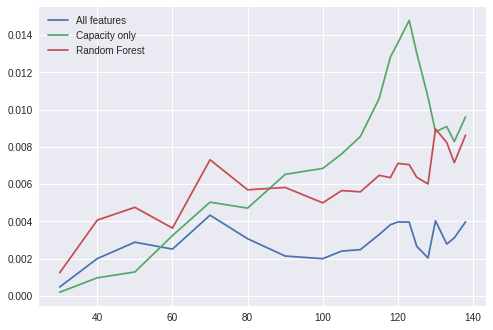

In [161]:
plt.plot(ty_list, average_RMSPE, label='All features')
plt.plot(ty_list, average_RMSPE_cap_only, label='Capacity only')
plt.plot(ty_list, average_RMSPE_rf, label='Random Forest')
plt.legend()

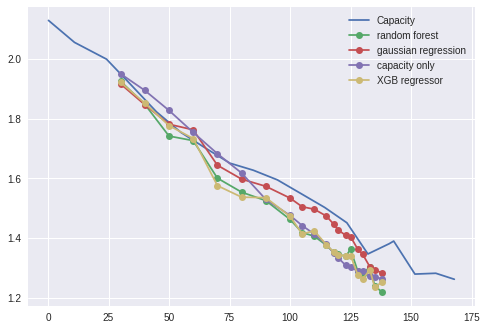

In [135]:
sample = 'RW13'
df2 = df[df['File'] == sample]

plt.plot(df2['total time'], df2['Capacity'])
plt.plot(y_pred_df_rf.columns, y_pred_df_rf.loc[sample], marker='o', label='random forest')
plt.plot(y_pred_df.columns, y_pred_df.loc[sample], marker='o', label='gaussian regression')
plt.plot(y_pred_df_cap_only.columns, y_pred_df_cap_only.loc[sample], marker='o', label='capacity only')
plt.plot(y_pred_df_xgb.columns, y_pred_df_xgb.loc[sample], marker='o', label='XGB regressor')

plt.legend()

In [0]:
y_pred_df_cap_only

In [0]:
import xgboost as xgb

In [0]:
xg_reg = xgb.XGBRegressor(objective ='reg:linear', colsample_bytree = 0.3, learning_rate = 0.1,
                max_depth = 5, alpha = 10, n_estimators = 100)

In [0]:
col_list = ['dQdV Peak location', 'dQdV Peak height', 'dVdQ Peak location', 'dVdQ Peak height', 'Peak shift', 'Capacity']

# +1 as also have the initial time value
X_total = np.ndarray((len(files_to_plot), (len(time_values)+1)*len(col_list)))

for count, file in enumerate(files_to_plot):
    df_file = df[df['File'] == file]
    time = df_file['total time']
    X = np.array([])
    for item in col_list:
        time_series = df_file[item]
        
        f = splrep(time, time_series, k=1, s=0.0)
        
        X = np.append(X, [list(time_series)[0]])
        X = np.append(X, splev(time_values, f))
        
    X_total[count, :] = X
    
## Getting y
def getting_y(ty):
    y = np.array([])
    for file in files_to_plot:
        df_file = df[df['File'] == file]
        capacity = df_file['Capacity']
        time = df_file['total time']
        f = splrep(time, capacity, k=1, s=0.0)
        y = np.append(y, splev(ty, f))
        
    return y

scaler = preprocessing.MinMaxScaler()
X_scaled = scaler.fit_transform(X_total)

average_RMSPE_xgb = []
y_var_list = []

y_pred_df_xgb = pd.DataFrame(index=files_to_plot, columns=ty_list)
for ty in ty_list:
    
    y = getting_y(ty)
    y_var_list.append(np.sqrt(np.var(y)))
    
    
    xg_reg = xgb.XGBRegressor(objective ='reg:linear', colsample_bytree = 0.3, learning_rate = 0.1,
                max_depth = 5, alpha = 10, n_estimators = 500)

    
    loo = LeaveOneOut()
    y_pred = cross_val_predict(reg, X_scaled, y, cv=loo)
    score = mean_squared_error(y, y_pred)
    average_RMSPE_xgb.append(score)
    y_pred_df_xgb.loc[:, ty] = y_pred

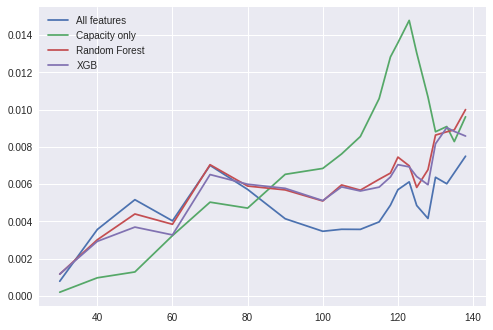

In [134]:
plt.plot(ty_list, average_RMSPE, label='All features')
plt.plot(ty_list, average_RMSPE_cap_only, label='Capacity only')
plt.plot(ty_list, average_RMSPE_rf, label='Random Forest')
plt.plot(ty_list, average_RMSPE_xgb, label='XGB')

plt.legend()

In [144]:
np.sqrt(0.004)

0.06324555320336758